In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [35]:
N = 1000
alpha = 2.3
noise = 2.0
slope = 4.0
x = np.random.normal(size=N)
y = alpha + slope * x + noise * np.random.normal(size=N)

data = {
  'x': x.astype(float),
  'y': y.astype(float),
  'N': N
}

program_code = """
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}

parameters {
  real alpha;
  real slope;
  real noise;
}

model {
  noise ~ inv_gamma(1, 1);
  alpha ~ normal(0, 10);
  slope ~ normal(0, 10);
  for (n in 1:N) {
    y[n] ~ normal(alpha + slope * x[n], noise);
  }
}
"""

In [36]:
diff_model = stan.build(program_code=program_code, data=data)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_4hl9uriv/model_tcvnuz5i.stan', line 19, column 40: A
    normal distribution is given parameter noise as a scale parameter
    (argument 2), but noise was not constrained to be strictly positive.
Warning in '/tmp/httpstan_4hl9uriv/model_tcvnuz5i.stan', line 15, column 2: Parameter
    noise is given a inv_gamma distribution, which has strictly positive
    support, but noise was not constrained to be strictly positive.


In [37]:
fit = diff_model.sample(num_chains=4, num_samples=1000, num_warmup=500)
df = fit.to_frame()

Sampling:   0%
Sampling:   5% (300/6000)
Sampling:  30% (1800/6000)
Sampling:  55% (3300/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000195 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000154 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.54 seconds.
  Adjust your expectations accordingly!
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: normal_lpdf: Scale parameter is -1.94069, but must be positive! (in '/tmp/httpstan_79uj5t6t/model_tcvnuz5i.stan', line 19, column 4 to column 47)
  Gradient evaluation took 0.000147 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.47 seconds.
  Adjust your expectations accordingly!
  Informational Message

In [38]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.268,0.064,2.157,2.397,0.001,0.001,4013.0,2710.0,1.0
noise,1.980,0.044,1.902,2.065,0.001,0.000,4112.0,2940.0,1.0
slope,4.104,0.062,3.980,4.216,0.001,0.001,3990.0,3192.0,1.0


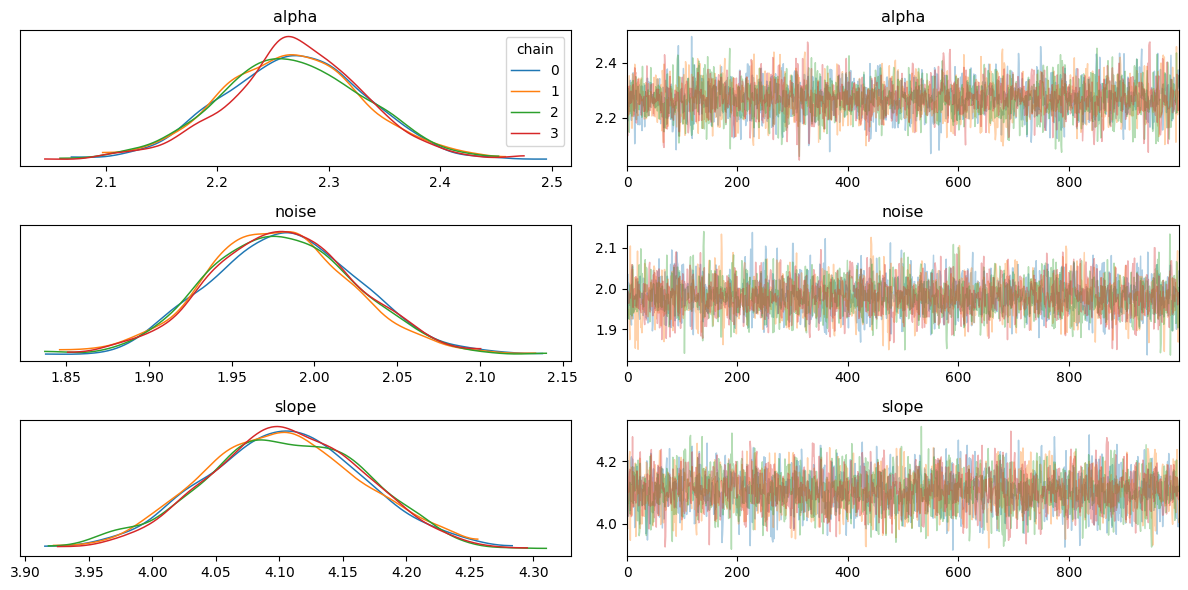

In [39]:
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

ANALYSIS

1. It appears that the posterior means are fairly close to the actual values, especially for those of alpha and slope. Noise is slightly off however, and the uncertainty remains fairly high for all three values.

2. With 10x as many observations, the posterior means appear to become more centralized and accurate, as the means differ from the actual by around 0.05 for each value. The uncertainty however has decreased.